# Validating Quantile Uncertainty Formula

This notebook validates the theoretical formula for the standard error of empirical p-values when estimating quantiles from a sample, and additionally validates the Gumbel approximation for the maximum error across multiple experiments.

## Background

When we estimate quantiles from a sample of size $n$, the empirical p-values (the proportion of samples below each quantile) have uncertainty due to sampling variability. The theoretical standard error of these empirical p-values is given by:

$$\sigma_p = \sqrt{\frac{q(1-q)}{n}}$$

where:
- $q$ is the target quantile level (e.g., 0.5 for median, 0.95 for 95th percentile)
- $n$ is the sample size
- $\sigma_p$ is the standard error of the empirical p-value

Additionally, when averaging over all quantile levels $q \in [0,1]$, the unconditional standard deviation is:

$$\sigma_{unconditional} = \sqrt{\frac{1}{6n}}$$

## Gumbel Maximum Approximation

When performing multiple experiments (e.g., $m$ independent trials), we're interested in the distribution of the maximum error across all experiments. For large $m$, the maximum of $m$ independent standard normal random variables follows a Gumbel distribution. The expected maximum scales as:

$$\text{max\_scale\_factor} = \sqrt{2\log(m)}$$

This means the expected maximum error across $m$ experiments is approximately:

$$\text{max\_error} \approx \sigma_p \times \sqrt{2\log(m)}$$

## Validation Approach

We simulate this process by:
1. Drawing samples from a standard normal distribution
2. Computing empirical quantiles at various levels
3. Converting quantiles back to p-values using the normal CDF
4. Comparing the observed standard deviation of p-value errors with the theoretical formula
5. Comparing the observed maximum error across experiments with the Gumbel approximation

This validates that both the standard error formula and the Gumbel maximum approximation correctly capture the uncertainty in quantile estimation across multiple experiments.



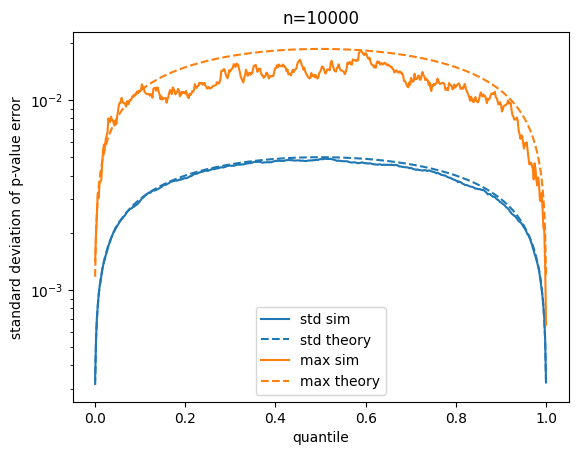

total standard deviation: sim 0.00394686808793771 theory 0.004082482904638631 max-factor 3.7169221888498383


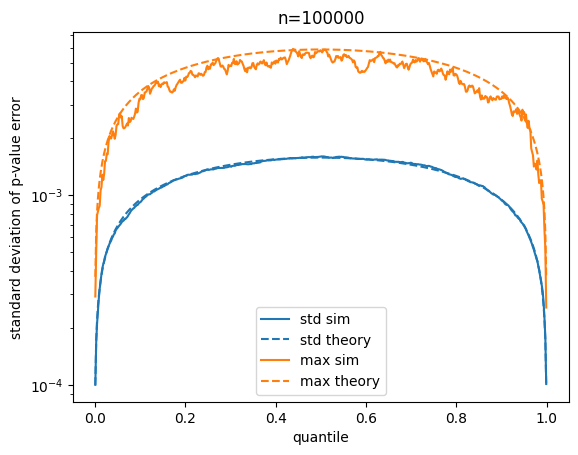

total standard deviation: sim 0.001288724952665991 theory 0.0012909944487358056 max-factor 3.7169221888498383


In [3]:
import numpy as np
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt

np.random.seed(42)

quantile_pvalues = np.linspace(0.001, 0.999, 512)
quantile_pvalues_torch = torch.from_numpy(quantile_pvalues)

num_samples = [10_000, 100_000]
num_experiments = 1000


for n in num_samples:
    # gumble approc for lage n
    max_scale_factor = np.sqrt(2*np.log(num_experiments))

    err = np.zeros((num_experiments, 512))
    for i in range(num_experiments):

        # distrubtion samples
        x_samples = np.random.normal(0, 1, n)
        x_samples_torch = torch.from_numpy(x_samples)

        # compute the quantiles of the samples
        x_quantiles_torch = torch.quantile(x_samples_torch, quantile_pvalues_torch)
        x_quantiles = x_quantiles_torch.numpy()

        sample_pvalues = norm.cdf(x_quantiles)
        err[i, :] = sample_pvalues - quantile_pvalues

    theo_std =  np.sqrt(quantile_pvalues*(1-quantile_pvalues)/n)
    plt.plot(quantile_pvalues, np.std(err,axis=0), label='std sim')
    plt.plot(quantile_pvalues, theo_std, 'C0', ls='--', label='std theory')
    
    plt.plot(quantile_pvalues, np.max(err,axis=0), 'C1', label='max sim')
    plt.plot(quantile_pvalues, theo_std*max_scale_factor, 'C1', ls='--', label='max theory')
    # log y axis scale
    plt.yscale('log')

    
    plt.legend()
    plt.title(f'n={n}')
    plt.xlabel('quantile')
    plt.ylabel('standard deviation of p-value error')
    plt.show()

    print('total standard deviation: sim', np.std(err), 'theory', np.sqrt(1/(6*n)), 'max-factor', max_scale_factor)

[-3.09023231e+00 -2.75295139e+00 -2.58238052e+00 -2.46455895e+00
 -2.37341883e+00 -2.29855304e+00 -2.23470992e+00 -2.17885468e+00
 -2.12906924e+00 -2.08406122e+00 -2.04291690e+00 -2.00496553e+00
 -1.96969969e+00 -1.93672584e+00 -1.90573241e+00 -1.87646834e+00
 -1.84872823e+00 -1.82234186e+00 -1.79716646e+00 -1.77308113e+00
 -1.74998252e+00 -1.72778155e+00 -1.70640090e+00 -1.68577300e+00
 -1.66583844e+00 -1.64654471e+00 -1.62784512e+00 -1.60969802e+00
 -1.59206606e+00 -1.57491559e+00 -1.55821624e+00 -1.54194046e+00
 -1.52606319e+00 -1.51056155e+00 -1.49541464e+00 -1.48060325e+00
 -1.46610973e+00 -1.45191780e+00 -1.43801243e+00 -1.42437967e+00
 -1.41100662e+00 -1.39788126e+00 -1.38499239e+00 -1.37232958e+00
 -1.35988308e+00 -1.34764374e+00 -1.33560303e+00 -1.32375289e+00
 -1.31208578e+00 -1.30059459e+00 -1.28927262e+00 -1.27811355e+00
 -1.26711140e+00 -1.25626053e+00 -1.24555560e+00 -1.23499152e+00
 -1.22456350e+00 -1.21426697e+00 -1.20409760e+00 -1.19405124e+00
 -1.18412397e+00 -1.17431

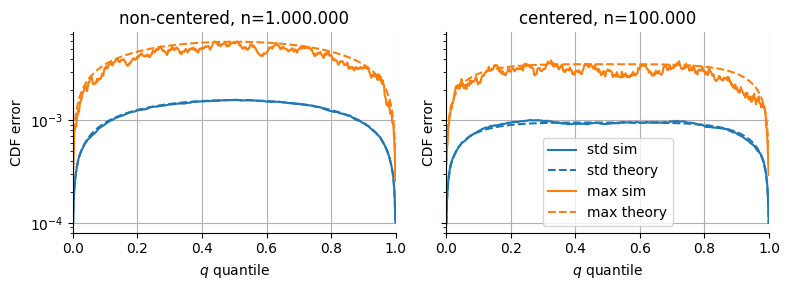

In [24]:



quantile_pvalues = np.linspace(0.001, 0.999, 512)
quantile_xvalues = norm.ppf(quantile_pvalues)
print(quantile_xvalues)
quantile_pvalues_torch = torch.from_numpy(quantile_pvalues)

num_samples = 100_000
num_experiments = 1_000


n = num_samples

# gumble approc for lage n
max_scale_factor = np.sqrt(2*np.log(num_experiments))


err = np.zeros((num_experiments, 512))
np.random.seed(42)

fig, axs = plt.subplots(1,2, figsize=(8, 3), sharex=True, sharey=True)

# Non-centered
ax = axs[0]
ax.set_title(f'non-centered, n=1.000.000')
for i in range(num_experiments):

    # distrubtion samples
    x_samples = np.random.normal(0, 1, n)
    x_samples_torch = torch.from_numpy(x_samples)
    
    # center
    x_samples_torch = x_samples_torch 

    # compute the quantiles of the samples
    x_quantiles_torch = torch.quantile(x_samples_torch, quantile_pvalues_torch)
    x_quantiles = x_quantiles_torch.numpy()

    sample_pvalues = norm.cdf(x_quantiles)
    err[i, :] = sample_pvalues - quantile_pvalues

theo_std =  np.sqrt(quantile_pvalues*(1-quantile_pvalues)/n )

ax.plot(quantile_pvalues, np.std(err,axis=0), label='std sim')
ax.plot(quantile_pvalues, theo_std, 'C0', ls='--', label='std theory')

ax.plot(quantile_pvalues, np.max(err,axis=0), 'C1', label='max sim')
ax.plot(quantile_pvalues, theo_std*max_scale_factor, 'C1', ls='--', label='max theory')


# Centered
ax = axs[1]
ax.set_title(f'centered, n=100.000')
for i in range(num_experiments):

    # distrubtion samples
    x_samples = np.random.normal(0, 1, n)
    x_samples_torch = torch.from_numpy(x_samples)
    
    # center
    x_samples_torch = x_samples_torch - x_samples_torch.mean()

    # compute the quantiles of the samples
    x_quantiles_torch = torch.quantile(x_samples_torch, quantile_pvalues_torch)
    x_quantiles = x_quantiles_torch.numpy()

    sample_pvalues = norm.cdf(x_quantiles)
    err[i, :] = sample_pvalues - quantile_pvalues

theo_std =  np.sqrt(quantile_pvalues*(1-quantile_pvalues)/n - norm.pdf(quantile_xvalues)**2/n)

ax.plot(quantile_pvalues, np.std(err,axis=0), label='std sim')
ax.plot(quantile_pvalues, theo_std, 'C0', ls='--', label='std theory')

ax.plot(quantile_pvalues, np.max(err,axis=0), 'C1', label='max sim')
ax.plot(quantile_pvalues, theo_std*max_scale_factor, 'C1', ls='--', label='max theory')


for ax in axs:
    ax.set_xlim(0, 1)  
    ax.set_yscale('log')
    ax.set_xlabel('$q$ quantile')
    ax.set_ylabel('CDF error')
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid()

axs[1].legend()

plt.tight_layout()
plt.savefig('quantile_error_n1m.png', dpi=300)
plt.show()
